In [1]:
import numpy as np
import pandas as pd
import sys
import seaborn
import matplotlib
import matplotlib.ticker
from matplotlib import pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
seaborn.set()
seaborn.set_style("white")
seaborn.set_context("poster") 


In [2]:
def get_threshold(ab_data, th=0.8):
    # ab_data is a crosses x ablation proportions array, th is threshold
    crosses, ranges = ab_data.shape
    for c in range(crosses):
        for r in range(ranges-1):
            if ab_data[c,r] >= th and ab_data[c,r+1] < th:
                x1 = r / (ranges-1)
                x2 = (r+1) / (ranges-1)
                y1 = ab_data[c,r]
                y2 = ab_data[c,r+1]
                m_inv = (x2 - x1) / (y2 - y1)
                ab_data[c,0] = (m_inv * (th - y1)) + x1  # store in the 0 column
                break
    return ab_data[:, 0]  # return 0 column


def update_results(ablation_results, factor, curve_idx, size_idx, factor_multiplier):

    ### CHANGED
    ablation_results = get_threshold(ablation_results) * (1/factor) * factor_multiplier
    results[seed, :, curve_idx, size_idx] =  ablation_results
    results_no[seed,: , curve_idx, size_idx] = 1/2**(4-size_idx) - ablation_results


    
def get_mean_std(res, maximum=True):

    results_tmp=np.zeros((curves,sizes,2))
    if maximum:
        results_tmp[:,:,0] = np.mean( np.max(res, axis=1), axis=(0))
        results_tmp[:,:,1] = np.std( np.max(res, axis=1), axis=(0))
    else:
        results_tmp[:,:,0] = np.mean( np.min(res, axis=1), axis=(0))
        results_tmp[:,:,1] = np.std( np.min(res, axis=1), axis=(0))   
    return results_tmp

def get_slope(res):
    
    res[res == 0]  = np.nan

    res_tmp = np.zeros((np.shape(res)[0],np.shape(res)[1]-1))
    for i in range(0,np.shape(res)[1]-1):
        res_tmp[:, i] = (res[:,i+1,0] / res[:,i,0] )
    x = np.nanmean(res_tmp, axis=1)
    #x = res_tmp
    x  = x [~np.isnan(x )]
    return x

def print_ablation(title, data, marker_styles, curve_colors, curve_styles, 
                   curve_labels, yticks, leg_title, rand_base, leg_loc, leg_flag, 
                   name, log_y, non, slopes, ncol=1, include_xlabel=True, include_ylabel=True):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.xaxis.tick_bottom() ### CHANGED
    ax.yaxis.tick_left() ### CHANGED
    plt.title(title , fontsize=25)
    if include_xlabel:
        plt.xlabel(r'Model Size Factor', fontsize=25)
    plt.xlim((0.245, 4.07))
    if log_y:            
        plt.yscale('log', basey=2)
        plt.ylim((np.min(yticks), np.max(yticks)))
    else:
        from matplotlib.ticker import FormatStrFormatter            
        plt.ylim((0, np.max(yticks)))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
    if include_ylabel:
        if non:
            plt.ylabel('Non-Prunability', fontsize=25)
        else:
            plt.ylabel('Prunability', fontsize=25)

    #plt.grid(True, which='both')
    plt.xscale('log', basex=2)
    plt.xticks(size_factors, size_labels)
    plt.yticks(yticks)

    for curve_idx in range(np.shape(data)[0]):
        non_0_idx = (data[curve_idx,:,0] != 0)
        plt.errorbar(size_factors[non_0_idx], data[curve_idx,non_0_idx,0], yerr=data[curve_idx,non_0_idx,1].T,
                 marker=marker_styles[curve_idx], markersize=7, color=curve_colors[curve_idx],
                 linestyle=curve_styles[curve_idx], linewidth=3)
        
    if leg_flag:
        leg = plt.legend(curve_labels, loc=leg_loc, framealpha=0.8, fontsize=10, title=leg_title,ncol=ncol)
        leg.get_title().set_fontsize('10')
        
    import math
    if not np.any(np.isnan(data[:,3,0])):
        plt.annotate(r"$g_{max}=$" + "{:.2f}".format(np.max(slopes)), xy= (math.log(3,2), np.max(data[:,3,0])),\
                 horizontalalignment='right', fontsize=14)
    else:
        if not slopes.size==0:

            plt.annotate(r"$g_{max}=$" + "{:.2f}".format(np.max(slopes)), xy= (math.log(2,2), np.max(data[:,2,0])),\
                 horizontalalignment='right', verticalalignment='bottom', fontsize=14)
    if not slopes.size==0:
        plt.annotate(r"$g_{min}=$" + "{:.2f}".format(np.min(slopes)), xy= (math.log(2,2), np.min(data[:,1,0])),\
                 horizontalalignment='left', fontsize=14)
        
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(15)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)
    
    plt.rc('xtick',labelsize=8)

    
    plt.show()
    fig.savefig(name+".pdf",format='pdf', bbox_inches='tight',dpi=1000)
    
    
def set_results(ID, experiments, size_idx, knockout_range, layer=None):

    csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_robustness.csv'
    csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
    df = pd.read_csv(csv_file)

    ablation_results = np.zeros((crosses, range_len))
    for cross in range(crosses):
        for amount in range(range_len):
            if layer == None:
                ablation_results[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]
            else:
                ablation_results[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == str(layer)] \
                    [df['perturbation_name'] == 'Activation Knockout'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]

    return ablation_results
    
    

In [3]:
sys.path.append('../')
import experiments

range_len = 7
curves = 4
curve_labels = ['AlexNet-CIFAR', 'AlexNet-Random', 'ResNet56-CIFAR', 'ResNet56-Random']
curve_colors = ['darkblue', 'darkblue', 'indianred', 'indianred']
curve_styles = ['-', ':', '-', ':']
marker_styles = ['o', 'v', 'o', 'v']

sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3

seeds = 2
results = np.zeros((seeds, crosses, curves, sizes))
results_no = np.zeros((seeds, crosses, curves, sizes))
# all are indexed [size_factor][nn_type][avg/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets

for seed in range(seeds):
    for ID in range(62, 92):
        opt = experiments.opt[ID]

        if opt.dataset.random_labels:
            curve_idx = 1  # random labels
        elif opt.hyper.augmentation and opt.hyper.drop_train < 1:
            curve_idx = 0  # all regularizers
        else:
            continue
        
        ablation_results = set_results(ID, experiments, 
                            size_idx_map[opt.dnn.neuron_multiplier[0]], knockout_range)
        update_results(ablation_results, 4, curve_idx, \
                       size_idx_map[opt.dnn.neuron_multiplier[0]], opt.dnn.neuron_multiplier[0])
 
    for ID in range(217, 231):
        opt = experiments.opt[ID]

        if opt.dataset.random_labels:
            curve_idx = 3  # random labels
        elif opt.hyper.lr_bs_factor == 1:
            curve_idx = 2  # all regularizers
        else:
            continue

        ablation_results = set_results(ID, experiments, 
                        size_idx_map[opt.dnn.neuron_multiplier[0]], knockout_range)
        update_results(ablation_results, 4, curve_idx, \
                       size_idx_map[opt.dnn.neuron_multiplier[0]], opt.dnn.neuron_multiplier[0])

results = get_mean_std(results)
results_no = get_mean_std(results_no, False)

slopes = get_slope(results)
slopes_no = get_slope(results_no)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


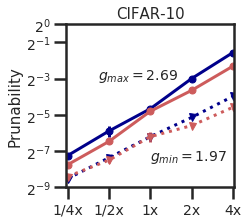

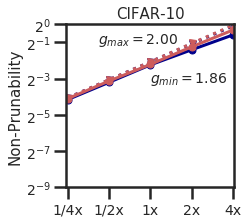

In [4]:
leg_loc = (0.05, -0.9)
yticks = [0, .20, .4, 0.6]  ### CHANGED
yticks_log = [1/512,1/128,  1/32,  1/8, 1/2,1]  ### CHANGED
yticks_log2 =  [0, 1/4,1/2,1] ### CHANGED

#                 "robust_norm_cifar_train", False)
print_ablation('CIFAR-10', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Network-Labels}$", 0.1,leg_loc, False,
                 "prune_cifar_rand", True, False, slopes, include_xlabel=False)

print_ablation('CIFAR-10', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Network-Labels}$", 0.1,leg_loc, False,
                 "nonprune_cifar_rand", True, True, slopes_no, include_xlabel=False)



In [5]:
sys.path.append('../')
import experiments

range_len = 7
curves = 5
curve_labels = ['None', 'All', 'DataAug.', 'Dropout', 'W. Decay']
curve_colors = ['slateblue', 'darkblue', 'purple', 'violet', 'pink']
curve_styles = ['-', '-', '--', '--', '--']
marker_styles = ['o', 'o', 'v', 'v', 'v']

sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3

seeds = 3
results = np.zeros((seeds, crosses, curves, sizes))
results_no = np.zeros((seeds, crosses, curves, sizes))

# all are indexed [size_factor][nn_type][avg/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets

for seed in range(seeds):
    for ID in range(62, 92):
        opt = experiments.opt[ID]

        curve_idx = 0  # unregularized
        if opt.dataset.random_labels:
            continue  # random labels
        elif opt.hyper.augmentation and opt.hyper.drop_train < 1:
            curve_idx = 1  # all regularizers
        elif opt.hyper.augmentation:
            curve_idx = 2
        elif opt.hyper.drop_train < 1:
            curve_idx = 3
        elif opt.hyper.weight_decay:
            curve_idx = 4

        ablation_results = set_results(ID, experiments, 
                        size_idx_map[opt.dnn.neuron_multiplier[0]], knockout_range)
        update_results(ablation_results, 4, curve_idx, \
                       size_idx_map[opt.dnn.neuron_multiplier[0]], opt.dnn.neuron_multiplier[0])
              
results = get_mean_std(results)
results_no = get_mean_std(results_no, False)

slopes = get_slope(results)
slopes_no = get_slope(results_no)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


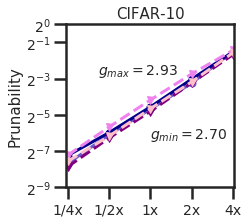

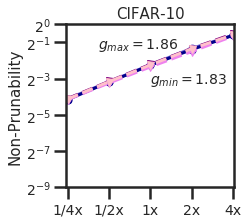

In [6]:
leg_loc = (-0.22, -0.8)

yticks = [0, 20, 40, 60]  ### CHANGED
yticks_log = [1/512,1/128,  1/32,  1/8, 1/2,1]  ### CHANGED
yticks_log2 =  [0, 1/4,1/2,1] ### CHANGED


print_ablation('CIFAR-10', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Regularizer}$", 0.1,leg_loc, False,
                 "prune_cifar_regularizers", True, False, slopes, ncol=2, include_xlabel=False)



print_ablation('CIFAR-10', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Regularizer}$", 0.1,leg_loc, False,
                 "nonprune_cifar_regularizers", True, True, slopes_no, include_xlabel=False)



In [7]:
#Batch - CIFAR
sys.path.append('../')
import experiments

range_len = 7
curves = 6
curve_labels = ['AlexNet-k=1', 'AlexNet-k=0.25', 'AlexNet-k=4', 'ResNet-k=1', 'ResNet-k=0.25', 'ResNet-k=4']
curve_colors = ['slateblue', 'lightblue', 'lightblue', 'indianred', 'mistyrose', 'mistyrose']
curve_styles = ['-', '--', '--', '-', '--', '--']
marker_styles = ['o', 'v', 's', 'o', 'v', 's']
lr_factor = [1, 0.25, 4]

sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3

seeds = 2
results = np.zeros((seeds, crosses, curves, sizes))
results_no = np.zeros((seeds, crosses, curves, sizes))

# all are indexed [size_factor][nn_type][avg/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets


for seed in range(seeds):
    for ID in list(range(62, 92)) + list(range(157,217)) :

        #print('Processing ID:', ID)
        opt = experiments.opt[ID]

        if opt.dataset.random_labels:
            continue
        if not (opt.hyper.augmentation or opt.hyper.drop_train < 1 or opt.hyper.weight_decay):
            curve_idx = np.where(np.array(opt.hyper.lr_bs_factor) == lr_factor)[0][0]
        else:
            continue
            
        if ID == 166: #Not possible to calculate
            continue

        ablation_results = set_results(ID, experiments, 
                        size_idx_map[opt.dnn.neuron_multiplier[0]], knockout_range)
        update_results(ablation_results, 4, curve_idx, \
                       size_idx_map[opt.dnn.neuron_multiplier[0]], opt.dnn.neuron_multiplier[0])
        
    for ID in list(range(217,232)) + list(range(234,239)):

        #print('Processing ID:', ID)
        opt = experiments.opt[ID]

        if opt.dataset.random_labels:
            continue
        else:
            curve_idx = np.where(np.array(opt.hyper.lr_bs_factor) == lr_factor)[0][0] + 3
            
        ablation_results = set_results(ID, experiments, 
                        size_idx_map[opt.dnn.neuron_multiplier[0]], knockout_range)
        update_results(ablation_results, 4, curve_idx, \
                       size_idx_map[opt.dnn.neuron_multiplier[0]], opt.dnn.neuron_multiplier[0])
        
results = get_mean_std(results)
results_no = get_mean_std(results_no, False)

slopes = get_slope(results)
slopes_no = get_slope(results_no)

        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


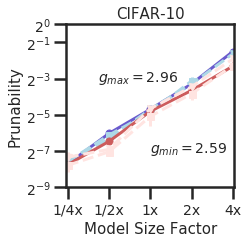

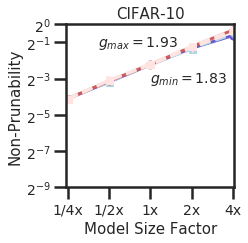

In [8]:
leg_loc = (0.0, 0.42)
yticks = [0, 20, 40, 60]  ### CHANGED
yticks_log = [1/512,1/128,  1/32,  1/8, 1/2, 1]  ### CHANGED
yticks_log2 =  [0, 1/4,1/2,1] ### CHANGED


print_ablation('CIFAR-10', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Network-k}$", 0.1,leg_loc, False,
                 "prune_cifar_batch", True, False, slopes)

print_ablation('CIFAR-10', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Network-k}$", 0.1,leg_loc, False,
                 "nonprune_cifar_batch", True, True, slopes_no)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:129: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


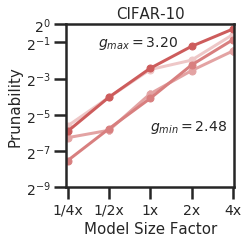

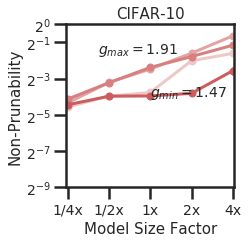

In [9]:
#Layer - CIFAR
sys.path.append('../')
import experiments

range_len = 7
curves = 4
curve_labels = ['c1',  'c2', 'fc1', 'fc2']
cm = seaborn.light_palette("indianred", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=curves+1)][1:]
curve_styles = ['-', '-', '-', '-', '-']
marker_styles = ['o', 'o', 'o', 'o', 'o']

sizes = 5
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3

seeds = 2
results = np.zeros((seeds, crosses, curves, sizes))
results_no = np.zeros((seeds, crosses, curves, sizes))
# all are indexed [size_factor][nn_type][avg/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets


for seed in range(seeds):        
    for ID in list(range(217,232)) + list(range(234,239)):
        for curve_idx, layer in enumerate([0, 1, 2, 3]):

            #print('Processing ID:', ID)
            opt = experiments.opt[ID]


            if opt.dataset.random_labels or not opt.hyper.lr_bs_factor == 1:
                continue
                
            size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

            ablation_results = set_results(ID, experiments, 
                            size_idx_map[opt.dnn.neuron_multiplier[0]], knockout_range, layer)
            update_results(ablation_results, 4, curve_idx, \
                           size_idx_map[opt.dnn.neuron_multiplier[0]], opt.dnn.neuron_multiplier[0])
              
results = get_mean_std(results)
results_no = get_mean_std(results_no, False)

slopes = get_slope(results)
slopes_no = get_slope(results_no)


leg_loc = (0.0, 0.42)
  
    
print_ablation('CIFAR-10', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Layer}$", 0.1,leg_loc, False,
                 "prune_cifar_layer", True, False, slopes)

print_ablation('CIFAR-10', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Layer}$", 0.1,leg_loc, False,
                 "nonprune_cifar_layer", True, True, slopes_no)



In [10]:
#Init - CIFAR
sys.path.append('../')
import experiments

range_len = 7
curves = 3
curve_labels = ['Glorot Norm', 'He Norm', 'Lecun Norm']
curve_colors = ['slateblue', 'skyblue', 'steelblue']
curve_styles = ['-',  '-',  '-']
marker_styles = ['o', 'o','o']

sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3

seeds = 3
results = np.zeros((seeds, crosses, curves, sizes))
results_no = np.zeros((seeds, crosses, curves, sizes))

# all are indexed [size_factor][nn_type][avg/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets


for seed in range(seeds):
    for ID in range(2,32):

        opt = experiments.opt[ID]

        curve_idx = opt.init_type // 2
        if opt.init_type in [1, 3, 5]:
            continue
        
        ablation_results = set_results(ID, experiments, 
                        size_idx_map[opt.dnn.neuron_multiplier[0]], knockout_range)
        update_results(ablation_results, 4, curve_idx, \
                       size_idx_map[opt.dnn.neuron_multiplier[0]], opt.dnn.neuron_multiplier[0])
        
results = get_mean_std(results)
results_no = get_mean_std(results_no, False)

slopes = get_slope(results)
slopes_no = get_slope(results_no)
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


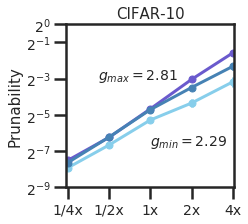

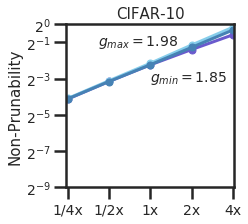

array([2.81017321, 2.29080474, 2.52581769])

In [11]:
leg_loc = (0.15, -0.8)
leg_loc_log = (0.48, 0.01)
yticks = [0, 20, 40, 60]  ### CHANGED
yticks_log = [1/512,1/128,  1/32,  1/8, 1/2, 1]  ### CHANGED
yticks_log2 = [0, 1/4, 1/2, 1]  ### CHANGED


print_ablation('CIFAR-10', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 0.1,leg_loc, False,
                 "prune_cifar_initializers", True, False, slopes, include_xlabel=False)

print_ablation('CIFAR-10', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 0.1,leg_loc_log, False,
                 "nonprune_cifar_initializers", True, True, slopes_no, include_xlabel=False)
slopes


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:129: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


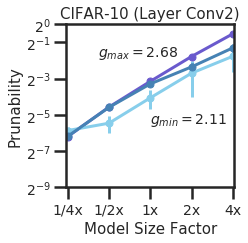

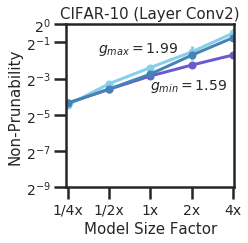

array([2.68422781, 2.11049244, 2.36925165])

In [12]:
#Init - CIFAR

range_len = 7
curves = 3
curve_labels = ['Glorot Norm', 'He Norm', 'Lecun Norm']
curve_colors = ['slateblue', 'skyblue', 'steelblue']
curve_styles = ['-',  '-',  '-']
marker_styles = ['o', 'o','o']

sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3

seeds = 3
results = np.zeros((seeds, crosses, curves, sizes))
results_no = np.zeros((seeds, crosses, curves, sizes))

for seed in range(seeds):
    for ID in range(2,32):

        opt = experiments.opt[ID]

        curve_idx = opt.init_type // 2
        if opt.init_type in [1, 3, 5]:
            continue
        
        ablation_results = set_results(ID, experiments, 
                        size_idx_map[opt.dnn.neuron_multiplier[0]], knockout_range, layer=1)
        update_results(ablation_results, 4, curve_idx, \
                       size_idx_map[opt.dnn.neuron_multiplier[0]], opt.dnn.neuron_multiplier[0])
        
results = get_mean_std(results)
results_no = get_mean_std(results_no, False)

slopes = get_slope(results)
slopes_no = get_slope(results_no)

leg_loc = (0.15, -0.8)
yticks = [0, 20, 40, 60]  ### CHANGED
yticks_log = [1/512,1/128,  1/32,  1/8, 1/2, 1]  ### CHANGED
yticks_log2 = [0, 1/4, 1/2, 1]  ### CHANGED


print_ablation('CIFAR-10 (Layer Conv2)', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 0.1,leg_loc, False,
                 "prune_cifar_initializers_conv2", True, False, slopes)

print_ablation('CIFAR-10 (Layer Conv2)', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 0.1,leg_loc, False,
                 "nonprune_cifar_initializers_conv2", True, True, slopes_no)
slopes

In [13]:
#Init - CIFAR
sys.path.append('../')
import experiments

range_len = 7
curves = 3
curve_labels = ['Glorot Unif.', 'He Unif.', 'Lecun Unif.']
curve_colors = ['slateblue', 'skyblue',  'steelblue']
curve_styles = ['--', '--', '--']
marker_styles = ['v', 'v', 'v']

sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 2

seeds = 3
results = np.zeros((seeds, crosses, curves, sizes))
results_no = np.zeros((seeds, crosses, curves, sizes))

# all are indexed [size_factor][nn_type][avg/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets


for seed in range(seeds):
    for ID in range(2,32):

        opt = experiments.opt[ID]

        curve_idx = opt.init_type // 2
        if opt.init_type in [0, 2, 4]:
            continue 
            
        ablation_results = set_results(ID, experiments, 
                        size_idx_map[opt.dnn.neuron_multiplier[0]], knockout_range)
        update_results(ablation_results, 4, curve_idx, \
                       size_idx_map[opt.dnn.neuron_multiplier[0]], opt.dnn.neuron_multiplier[0])
        
results = get_mean_std(results)
results_no = get_mean_std(results_no, False)

slopes = get_slope(results)
slopes_no = get_slope(results_no)
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


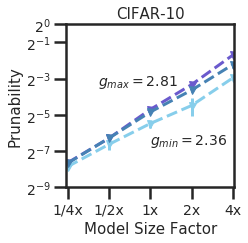

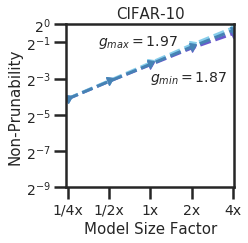

array([2.80985603, 2.35712211, 2.57462475])

In [14]:
leg_loc = (0.01, 0.49)
yticks = [0, 20, 40, 60]  ### CHANGED
yticks_log = [1/512,1/128,  1/32,  1/8, 1/2, 1]  ### CHANGED
yticks_log2 =  [0, 1/4,1/2,1] ### CHANGED


print_ablation('CIFAR-10', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 0.1,leg_loc, False,
                 "prune_cifar_initializers_uni", True, False, slopes)


print_ablation('CIFAR-10', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 0.1,leg_loc, False,
                 "nonprune_cifar_initializers_uni", True, True, slopes_no)
slopes

In [15]:
import pickle

with open('ids_mlps.p', 'rb') as handle:
    IDs = pickle.load(handle)
    
dataset_idx_map = {"rand10": 0, "rand10000": 1}
data_idx_map = {1e3: 0, 1e4: 1, 1e5: 2}
optimizer_idx_map = {0: 0, 1: 1, 2: 2, 5: 3}
init_idx_map = {1e-2: 0, 1e-1:1, 1:2, 1e1:3, 1e2:4, 1e3:5, 1e4:6, 1e5:7, 1e6:8, 1e7:9}


In [16]:
#Base - MLPs

sys.path.append('../')
import experiments

range_len = 7
sizes = 5
curves = 3
curve_labels = ['1K', '10K', '100K']
curve_colors = ['orange', 'orange', 'orange']
curve_styles = ['-', '--',':' ]
marker_styles = ['o', 'o', 'o']

size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3
factors = [1, 2, 4, 8, 16]
#select_lr = [1e-1, 1e-2, 1e-3, 1e-3]

seeds = 3

#inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]  ### SC

results = np.zeros((seeds, crosses, curves, sizes))
results_no = np.zeros((seeds, crosses, curves, sizes))

# both are indexed [nn_type][size_factor]
# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for curve_idx in range(curves):
        
        optimizer_idx = 0
        
        if curve_idx == 0:
            dataset_idx = dataset_idx_map["rand10"]
            data_idx = data_idx_map[1e3]
        elif  curve_idx == 1:
            dataset_idx = dataset_idx_map["rand10"]
            data_idx = data_idx_map[1e4]
        elif  curve_idx == 2:
            dataset_idx = dataset_idx_map["rand10"]
            data_idx = data_idx_map[1e5]
         
        for size_idx in range(sizes):
            id_best = int(IDs[1][seed, dataset_idx, data_idx, optimizer_idx, size_idx])
            opt = experiments.opt[id_best]
              
            ablation_results = set_results(id_best, experiments, \
                        size_idx, knockout_range)
            update_results(ablation_results, 16, curve_idx, size_idx, opt.dnn.neuron_multiplier[0])
                    
results = get_mean_std(results)
results_no = get_mean_std(results_no, False)

slopes = get_slope(results)
slopes_no = get_slope(results_no)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


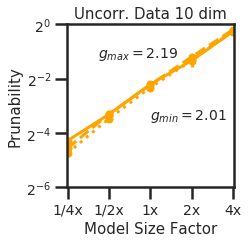

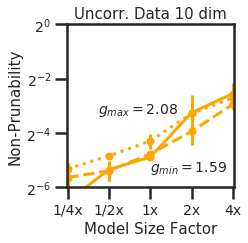

In [17]:
yticks = [0, 20, 40, 60, 80, 100]  ### CHANGED
yticks_log = [1/64,1/16, 1/4,1 ]  ### CHANGED
yticks_log2 = [0, 1/8, 1/4,1/2 ]  ### CHANGED
leg_loc1 = (0.02, 0.39)
leg_loc2 = (0.38, 0.01)


print_ablation('Uncorr. Data 10 dim', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"#$\bf{Data}$", 0.1,leg_loc1, False,
                 "prune_synth_10_data", True, False, slopes)

print_ablation('Uncorr. Data 10 dim', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"#$\bf{Data}$", 0.1,leg_loc2, False,
                 "nonprune_synth_10_data", True, True, slopes_no)



In [18]:
#Base - MLPs

sys.path.append('../')
import experiments

range_len = 7
sizes = 5
curves = 3
curve_labels = ['1K', '10K', '100K']
curve_colors = ['purple','purple','purple']
curve_styles = [ '-', '--', ':']
marker_styles = [ 'v',  'v','v']

size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3
factors = [1, 2, 4, 8, 16]
#select_lr = [1e-1, 1e-2, 1e-3, 1e-3]

seeds = 3

#inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]  ### SC

results = np.zeros((seeds, crosses, curves, sizes))
results_no = np.zeros((seeds, crosses, curves, sizes))

# both are indexed [nn_type][size_factor]
# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for curve_idx in range(curves):
        
        optimizer_idx = 0
        
        if curve_idx == 0:
            dataset_idx = dataset_idx_map["rand10000"]
            data_idx = data_idx_map[1e3]
        elif  curve_idx == 1:
            dataset_idx = dataset_idx_map["rand10000"]
            data_idx = data_idx_map[1e4]
        elif  curve_idx == 2:
            dataset_idx = dataset_idx_map["rand10000"]
            data_idx = data_idx_map[1e5]
         
        for size_idx in range(sizes):
            id_best = int(IDs[1][seed, dataset_idx, data_idx, optimizer_idx, size_idx])
            opt = experiments.opt[id_best]
              
            ablation_results = set_results(id_best, experiments, \
                        size_idx, knockout_range)
            update_results(ablation_results, 16, curve_idx, size_idx, opt.dnn.neuron_multiplier[0])
                    
results = get_mean_std(results)
results_no = get_mean_std(results_no, False)

slopes = get_slope(results)
slopes_no = get_slope(results_no)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


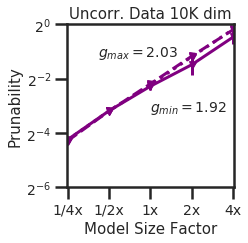

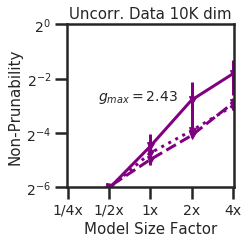

In [19]:
yticks = [0, 20, 40, 60, 80, 100]  ### CHANGED
yticks_log = [1/64,1/16, 1/4,1 ]  ### CHANGED
yticks_log2 = [0, 1/8, 1/4,1/2 ]  ### CHANGED
leg_loc1 = (0.02, 0.39)
leg_loc2 = (0.38, 0.01)


print_ablation('Uncorr. Data 10K dim', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"#$\bf{Data}$", 0.1,leg_loc1, False,
                 "prune_synth_10k_data", True, False, slopes)

print_ablation('Uncorr. Data 10K dim', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"#$\bf{Data}$", 0.1,leg_loc2, False,
                 "nonprune_synth_10k_data", True, True, slopes_no)


In [20]:
#Base - MLPs

sys.path.append('../')
import experiments

range_len = 7
sizes = 5
curves = 4
curve_labels = ['Momentum', 'SGD', 'Adam', 'RMSprop']
curve_colors = ['orange','olive', 'olive', 'olive']
curve_styles = ['-','-', '--',':']
marker_styles = ['o', 'o', 'o', 'o']
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3
factors = [1, 2, 4, 8, 16]
#select_lr = [1e-1, 1e-2, 1e-3, 1e-3]

seeds = 3

#inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]  ### SC

results = np.zeros((seeds, crosses, curves, sizes))
results_no = np.zeros((seeds, crosses, curves, sizes))

# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for curve_idx in range(curves):
        
        optimizer_idx = 0
        data_idx = data_idx_map[1e3]
        if curve_idx == 0:
            dataset_idx = dataset_idx_map["rand10"]
            optimizer_idx = optimizer_idx_map[0]
        elif curve_idx == 1:
            dataset_idx = dataset_idx_map["rand10"]
            optimizer_idx = optimizer_idx_map[1]
        elif  curve_idx == 2:
            dataset_idx = dataset_idx_map["rand10"]
            optimizer_idx = optimizer_idx_map[2]
        elif  curve_idx == 3:
            dataset_idx = dataset_idx_map["rand10"]
            optimizer_idx = optimizer_idx_map[5]
         
        for size_idx in range(sizes):
            id_best = int(IDs[1][seed, dataset_idx, data_idx, optimizer_idx, size_idx])
            opt = experiments.opt[id_best]
              
            ablation_results = set_results(id_best, experiments, \
                        size_idx, knockout_range)
            update_results(ablation_results, 16, curve_idx, size_idx, opt.dnn.neuron_multiplier[0])
                    
results = get_mean_std(results)
results_no = get_mean_std(results_no, False)

slopes = get_slope(results)
slopes_no = get_slope(results_no)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


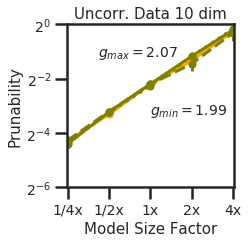

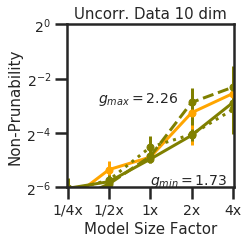

In [21]:
yticks = [0, 20, 40, 60, 80, 100]  ### CHANGED
yticks_log = [1/64,1/16, 1/4,1 ]  ### CHANGED
yticks_log2 = [1/8, 1/4,1/2 ]  ### CHANGED
leg_loc1 = (0.02, 0.39)
leg_loc2 = (0.38, 0.01)


print_ablation('Uncorr. Data 10 dim', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Optimizer}$", 0.1,leg_loc1, False,
                 "prune_synth_10_optimizer", True, False, slopes)

print_ablation('Uncorr. Data 10 dim', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Optimizer}$", 0.1,leg_loc2, False,
                 "nonprune_synth_10_optimizer", True, True, slopes_no)



In [22]:
#Base - MLPs

sys.path.append('../')
import experiments

range_len = 7
sizes = 5
curves = 4
curve_labels = ['Momentum', 'SGD', 'Adam', 'RMSprop']
curve_colors = ['purple', 'peru','peru','peru']
curve_styles = ['-', '-', '--', ':']
marker_styles = ['v','v',  'v','v']
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3
factors = [1, 2, 4, 8, 16]
#select_lr = [1e-1, 1e-2, 1e-3, 1e-3]

seeds = 3

#inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]  ### SC

results = np.zeros((seeds, crosses, curves, sizes))
results_no = np.zeros((seeds, crosses, curves, sizes))

# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for curve_idx in range(curves):
        
        optimizer_idx = 0
        data_idx = data_idx_map[1e3]
        if curve_idx == 0:
            dataset_idx = dataset_idx_map["rand10000"]
            optimizer_idx = optimizer_idx_map[0]
        elif curve_idx == 1:
            dataset_idx = dataset_idx_map["rand10000"]
            optimizer_idx = optimizer_idx_map[1]
        elif  curve_idx == 2:
            dataset_idx = dataset_idx_map["rand10000"]
            optimizer_idx = optimizer_idx_map[2]
        elif  curve_idx == 3:
            dataset_idx = dataset_idx_map["rand10000"]
            optimizer_idx = optimizer_idx_map[5]
         
        for size_idx in range(sizes):
            id_best = int(IDs[1][seed, dataset_idx, data_idx, optimizer_idx, size_idx])
            opt = experiments.opt[id_best]
              
            ablation_results = set_results(id_best, experiments, \
                        size_idx, knockout_range)
            update_results(ablation_results, 16, curve_idx, size_idx, opt.dnn.neuron_multiplier[0])
                    
results = get_mean_std(results)
results_no = get_mean_std(results_no, False)

slopes = get_slope(results)
slopes_no = get_slope(results_no)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


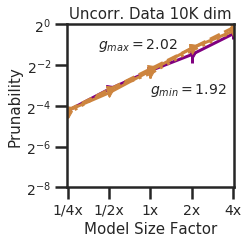

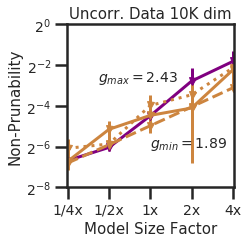

In [23]:
yticks = [0, 20, 40, 60, 80, 100]  ### CHANGED
yticks_log = [1/256, 1/64,1/16, 1/4, 1]  ### CHANGED
yticks_log2 = [1/8, 1/4,1/2 ]  ### CHANGED
leg_loc1 = (0.02, 0.39)
leg_loc2 = (0.38, 0.01)


print_ablation('Uncorr. Data 10K dim', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Optimizer}$", 0.1,leg_loc1, False,
                 "prune_synth_10k_optimizer", True, False, slopes)

print_ablation('Uncorr. Data 10K dim', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Optimizer}$", 0.1,leg_loc2, False,
                 "nonprune_synth_10k_optimizer", True, True, slopes_no)



In [24]:
#Init - MLPs

sys.path.append('../')
import experiments

range_len = 7
sizes = 5
curve_labels = ['1e-4', '1e-2', '1', '1e2', '1e4']
cm = seaborn.light_palette("purple", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=5)]
curve_styles = ['-', '-', '-', '-', '-']
marker_styles = ['o', 'o', 'o', 'o',  'o']
inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]
curves = 5

yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3
lr = [1, 1e-1, 1e-2, 1e-3, 1e-4]
factors = [1, 2, 4, 8, 16]
select_lr = [1e-1, 1e-2, 1e-3, 1e-3]

seeds = 3

inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]  ### SC

results = np.zeros((seeds, crosses, curves, sizes))
results_no = np.zeros((seeds, crosses, curves, sizes))

# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for curve_idx in range(curves):
        
        optimizer_idx = 0
        dataset_idx = dataset_idx_map["rand10000"]
        data_idx = data_idx_map[1e3]
        init_idx = init_idx_map[inits_fact[curve_idx]]
 
        for size_idx in range(sizes):
            id_best = int(IDs[0][seed, dataset_idx, data_idx, optimizer_idx, init_idx, size_idx])
            opt = experiments.opt[id_best]
              
            ablation_results = set_results(id_best, experiments, \
                        size_idx, knockout_range)
            update_results(ablation_results, 16, curve_idx, size_idx, opt.dnn.neuron_multiplier[0])
                    
results = get_mean_std(results)
results_no = get_mean_std(results_no, False)

slopes = get_slope(results)
slopes_no = get_slope(results_no)
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


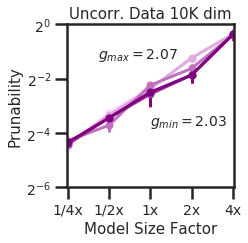

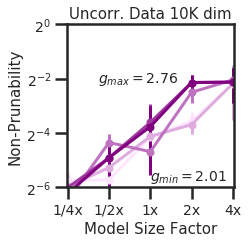

In [25]:
yticks = [0, 20, 40, 60, 80, 100]  ### CHANGED
yticks_log = [1/64,1/16, 1/4,1 ]  ### CHANGED
yticks_log2 = [0, 1/8, 1/4,1/2 ]  ### CHANGED
leg_loc1 = (0.02, 0.39)
leg_loc2 = (0.38, 0.01)


print_ablation('Uncorr. Data 10K dim', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 0.1,leg_loc1, False,
                 "prune_synth_10k_initializer", True, False, slopes)

print_ablation('Uncorr. Data 10K dim', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 0.1,leg_loc2, False,
                 "nonprune_synth_10k_initializer", True, True, slopes_no)



In [26]:
#Init - MLPs

sys.path.append('../')
import experiments

range_len = 7
sizes = 5
curve_labels = ['1e-4', '1e-2', '1', '1e2', '1e4']
cm = seaborn.light_palette("orange", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=5)]
curve_styles = ['-', '-', '-', '-', '-']
marker_styles = ['o', 'o', 'o', 'o',  'o']
inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]
curves = 5

yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3
lr = [1, 1e-1, 1e-2, 1e-3, 1e-4]
factors = [1, 2, 4, 8, 16]
select_lr = [1e-1, 1e-2, 1e-3, 1e-3]

seeds = 3

inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]  ### SC

results = np.zeros((seeds, crosses, curves, sizes))
results_no = np.zeros((seeds, crosses, curves, sizes))

# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for curve_idx in range(curves):
        
        optimizer_idx = 0
        dataset_idx = dataset_idx_map["rand10"]
        data_idx = data_idx_map[1e3]
        init_idx = init_idx_map[inits_fact[curve_idx]]
 
        for size_idx in range(sizes):
            id_best = int(IDs[0][seed, dataset_idx, data_idx, optimizer_idx, init_idx, size_idx])
            opt = experiments.opt[id_best]
              
            ablation_results = set_results(id_best, experiments, \
                        size_idx, knockout_range)
            update_results(ablation_results, 16, curve_idx, size_idx, opt.dnn.neuron_multiplier[0])
                    
results = get_mean_std(results)
results_no = get_mean_std(results_no, False)

slopes = get_slope(results)
slopes_no = get_slope(results_no)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


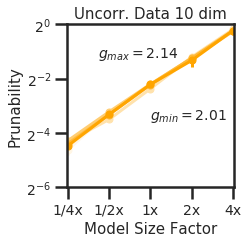

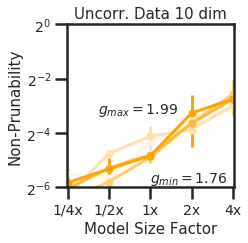

In [27]:
yticks = [0, 20, 40, 60, 80, 100]  ### CHANGED
yticks_log = [1/64,1/16, 1/4,1 ]  ### CHANGED
yticks_log2 = [0, 1/8, 1/4,1/2 ]  ### CHANGED
leg_loc1 = (0.02, 0.39)
leg_loc2 = (0.38, 0.01)


print_ablation('Uncorr. Data 10 dim', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 0.1,leg_loc1, False,
                 "prune_synth_10_initializer", True, False, slopes)

print_ablation('Uncorr. Data 10 dim', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 0.1,leg_loc2, False,
                 "nonprune_synth_10_initializer", True, True, slopes_no)



In [28]:
#Init - MLPs

sys.path.append('../')
import experiments

range_len = 7
sizes = 5
curve_labels = ['10dim - 1e-2', '10dim - 1', '10Kdim - 1e-2', '10Kdim - 1']
cm_orange = seaborn.light_palette("orange", as_cmap=True)
cm_purple = seaborn.light_palette("purple", as_cmap=True)

curve_colors = [cm_orange(0.45), cm_orange(0.75),cm_purple(0.45), cm_purple(0.75)]
curve_styles = ['-', '-',  '-', '-']
marker_styles = ['o', 'o',  'o',  'o']

curves = 4

yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3
factors = [1, 2, 4, 8, 16]

seeds = 3


results = np.zeros((seeds, crosses, curves, sizes))
results_no = np.zeros((seeds, crosses, curves, sizes))

# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for curve_idx in range(curves):
        
        optimizer_idx = 0
        if curve_idx < 2:
            dataset_idx = dataset_idx_map["rand10"]
        else:
            dataset_idx = dataset_idx_map["rand10000"]

        data_idx = data_idx_map[1e3]
        if curve_idx == 0 or curve_idx == 2:
            init_idx = init_idx_map[1e-2]
        else:
            init_idx = init_idx_map[1e0]
            
 
        for size_idx in range(sizes):
            id_best = int(IDs[0][seed, dataset_idx, data_idx, optimizer_idx, init_idx, size_idx])
            opt = experiments.opt[id_best]
              
            ablation_results = set_results(id_best, experiments, \
                        size_idx, knockout_range)
            update_results(ablation_results, 16, curve_idx, size_idx, opt.dnn.neuron_multiplier[0])
                    
results = get_mean_std(results)
results_no = get_mean_std(results_no, False)

slopes = get_slope(results)
slopes_no = get_slope(results_no)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


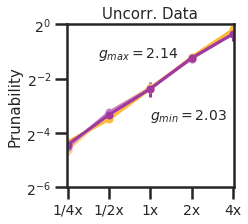

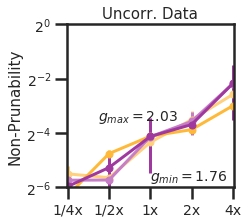

In [29]:
yticks = [0, 20, 40, 60, 80, 100]  ### CHANGED
yticks_log = [1/64,1/16, 1/4,1 ]  ### CHANGED
yticks_log2 = [0, 1/8, 1/4,1/2 ]  ### CHANGED

leg_loc = (0.1, -.85)


print_ablation('Uncorr. Data', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Dataset-Init.}$", 0.1,leg_loc, False,
                 "prune_synth_summary", True, False, slopes, include_xlabel=False)

print_ablation('Uncorr. Data', results_no, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Initializer}$", 0.1,leg_loc, False,
                 "nonprune_synth_summary", True, True, slopes_no, include_xlabel=False)



In [30]:
#Batch - ImageNet

sys.path.append('../')
sys.path.append('../ImageNet/')
from ImageNet.experiments import experiments

opts = experiments.get_experiments('','')

range_len = 7
sizes = 5
levels = np.array(np.linspace(0.0, 1.0, num=range_len))
knockout_range = np.linspace(0.0, 1.0, num=range_len)
level_labels = ["{:.0f}".format(a*100) for a in levels]

curves = 4
curve_labels = ['max.',  '4096', '2048', '1024']
curve_colors = ['indianred', 'salmon', 'salmon', 'salmon']
curve_styles = ['-', '-', '--', '--']
marker_styles = ['o', 'v', 's', 'D']
sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 1

ablation = np.zeros((curves, sizes, 2))
ablation_test = np.zeros((curves, sizes, 2))

for ID in range(5):
    #print('Processing ID:', ID)
    opt = opts[ID]    
    csv_file = opt.csv_dir + opt.name + '_robustness.csv'
    df = pd.read_csv(csv_file)
    
    size_idx = size_idx_map[opt.dnn.factor]
    
    rand_ablation_results = np.zeros((range_len))
    for amount in range(range_len):
        rand_ablation_results[amount] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_type'] == 2] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        
        

    # ablation[0, size_idx, 0] = np.mean(rand_ablation_results)
    ablation[0, size_idx, 0] = get_threshold(np.expand_dims(rand_ablation_results, 0)) * (1/4) * opt.dnn.factor
    ablation_test[0, size_idx, 0] = 1/2**(4-size_idx) - ablation[0, size_idx, 0]


batch_plot = [4096, 2048, 1024]
for ID in range(13):
    
    #print('Processing ID:', ID)
    opt = opts[ID]    
    csv_file = opt.csv_dir + opt.name + '_robustness.csv'
    df = pd.read_csv(csv_file)
    
    size_idx = size_idx_map[opt.dnn.factor]
    batch_idx = np.where(np.asarray(batch_plot) == opt.hyper.batch_size)[0]
    if len(batch_idx):
        rand_ablation_results = np.zeros((range_len))
        for amount in range(range_len):
            rand_ablation_results[amount] = \
                np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_type'] == 2] \
                        [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])

        ablation[int(batch_idx)+1, size_idx, 0] = get_threshold(np.expand_dims(rand_ablation_results, 0)) * (1/4) * opt.dnn.factor
        ablation_test[int(batch_idx)+1, size_idx, 0] = 1/2**(4-size_idx) - ablation[int(batch_idx)+1, size_idx, 0]
        
slopes = get_slope(ablation)
slopes_no = get_slope(ablation_test)



OPTS LOOKUP:
ID: 0, resnet, factor: 0.25, batch_size:8192
ID: 1, resnet, factor: 0.5, batch_size:4096
ID: 2, resnet, factor: 1, batch_size:3072
ID: 3, resnet, factor: 2, batch_size:1024
ID: 4, resnet, factor: 4, batch_size:512
ID: 5, resnet, factor: 0.25, batch_size:4096
ID: 6, resnet, factor: 0.25, batch_size:2048
ID: 7, resnet, factor: 0.5, batch_size:2048
ID: 8, resnet, factor: 1, batch_size:2048
ID: 9, resnet, factor: 0.25, batch_size:1024
ID: 10, resnet, factor: 0.5, batch_size:1024
ID: 11, resnet, factor: 1, batch_size:1024
ID: 12, inception, factor: 1, batch_size:512
ID: 13, inception, factor: 0.25, batch_size:512
ID: 14, inception, factor: 0.5, batch_size:512
ID: 15, inception, factor: 1, batch_size:512
ID: 16, inception, factor: 1, batch_size:512
ID: 17, inception, factor: 1, batch_size:512
ID: 18, inception, factor: 1, batch_size:512
ID: 19, resnet, factor: 0.25, batch_size:8192
ID: 20, resnet, factor: 0.5, batch_size:4096
ID: 21, resnet, factor: 1, batch_size:3072
ID: 22, re

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


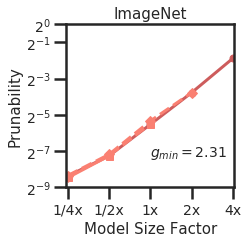

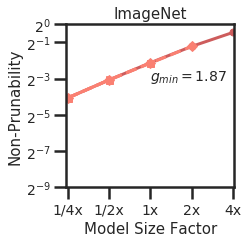

array([3.14551181, 2.30709588, 2.80196105, 2.92920989])

In [31]:
leg_loc = (0.0, 0.42)

yticks = [0, 20, 40, 60]  ### CHANGED
yticks_log = [ 1/512, 1/128,  1/32, 1/8, 1/2, 1]  ### CHANGED
yticks_log2 = [0,  1/4, 1/2, 1]  ### CHANGED


print_ablation('ImageNet', ablation, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Batch} \bf{Size}$", 0.1,leg_loc, False,
                 "prune_imagenet_batch", True, False, slopes)


print_ablation('ImageNet', ablation_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Batch} \bf{Size}$", 0.1,leg_loc, False,
                 "nonprune_imagenet_batch", True, True, slopes_no)

slopes

# yticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25]
# print_auc(r'ImageNet - Validation', ablation-targeted_ablation, marker_styles, 
#                curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Batch} \bf{Size}$", 0.1,leg_loc, False,
#                  "target_imagenet_batch_test")




In [32]:
#ImageNet

sys.path.append('../')
sys.path.append('../ImageNet/')
from ImageNet.experiments import experiments

opts = experiments.get_experiments('','')
range_len = 7

sizes = 5
levels = np.array(np.linspace(0.0, 1.0, num=range_len))
knockout_range = np.linspace(0.0, 1.0, num=range_len)
level_labels = ["{:.0f}".format(a*100) for a in levels]

range_len = 7
curves = 3
curve_labels = ['ResNet18',  'Inceptionv3', 'Inceptionv3-layer']
curve_colors = ['indianred', 'green', 'lightgreen']
curve_styles = ['-', '-', ':']
marker_styles = ['o', 'v', 's']
sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 1

ablation = np.zeros((curves, sizes, 2))
targeted_ablation = np.zeros((curves, sizes, 2))
for ID in range(5):
    #print('Processing ID:', ID)
    opt = opts[ID]    
    csv_file = opt.csv_dir + opt.name + '_robustness.csv'
    df = pd.read_csv(csv_file)
    
    size_idx = size_idx_map[opt.dnn.factor]
    
    rand_ablation_results = np.zeros((range_len))
    targeted_ablation_results = np.zeros((range_len))
    for amount in range(range_len):
        rand_ablation_results[amount] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_type'] == 2] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        

    ablation[0, size_idx, 0] = get_threshold(np.expand_dims(rand_ablation_results, 0)) * (1/4) * opt.dnn.factor
    targeted_ablation[0, size_idx, 0] = 1/2**(4-size_idx) -  ablation[0, size_idx, 0]


for ID in range(12,15):
    #print('Processing ID:', ID)
    opt = opts[ID]    
    csv_file = opt.csv_dir + opt.name + '_robustness.csv'
    df = pd.read_csv(csv_file)
    
    size_idx = size_idx_map[opt.dnn.factor]
    
    rand_ablation_results = np.zeros((range_len))
    targeted_ablation_results = np.zeros((range_len))
    for amount in range(range_len):
        rand_ablation_results[amount] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == '13'] \
                [df['perturbation_type'] == 2] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        

    ablation[1, size_idx, 0] = get_threshold(np.expand_dims(rand_ablation_results, 0)) * (1/4) * opt.dnn.factor
    targeted_ablation[1, size_idx, 0] = 1/2**(4-size_idx) -  ablation[1, size_idx, 0]
    
    
for ID in list(range(12,13)) + list(range(15,19)):
    #print('Processing ID:', ID)
    opt = opts[ID]    
    csv_file = opt.csv_dir + opt.name + '_robustness.csv'
    df = pd.read_csv(csv_file)
    
    size_idx = size_idx_map[opt.dnn.factor_end]
    
    rand_ablation_results = np.zeros((range_len))
    targeted_ablation_results = np.zeros((range_len))
    for amount in range(range_len):
        rand_ablation_results[amount] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == '7'] \
                [df['perturbation_type'] == 2] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        

    factor_map = {12: 1, 15: 0.25, 16: 0.5, 17: 2, 18: 4}
    ablation[2, size_idx, 0] = get_threshold(np.expand_dims(rand_ablation_results, 0)) * (1/4) * factor_map[ID]
    targeted_ablation[2, size_idx, 0] = 1/2**(4-size_idx) - ablation[2, size_idx, 0]


slopes = get_slope(ablation)
slopes_no = get_slope(targeted_ablation)


OPTS LOOKUP:
ID: 0, resnet, factor: 0.25, batch_size:8192
ID: 1, resnet, factor: 0.5, batch_size:4096
ID: 2, resnet, factor: 1, batch_size:3072
ID: 3, resnet, factor: 2, batch_size:1024
ID: 4, resnet, factor: 4, batch_size:512
ID: 5, resnet, factor: 0.25, batch_size:4096
ID: 6, resnet, factor: 0.25, batch_size:2048
ID: 7, resnet, factor: 0.5, batch_size:2048
ID: 8, resnet, factor: 1, batch_size:2048
ID: 9, resnet, factor: 0.25, batch_size:1024
ID: 10, resnet, factor: 0.5, batch_size:1024
ID: 11, resnet, factor: 1, batch_size:1024
ID: 12, inception, factor: 1, batch_size:512
ID: 13, inception, factor: 0.25, batch_size:512
ID: 14, inception, factor: 0.5, batch_size:512
ID: 15, inception, factor: 1, batch_size:512
ID: 16, inception, factor: 1, batch_size:512
ID: 17, inception, factor: 1, batch_size:512
ID: 18, inception, factor: 1, batch_size:512
ID: 19, resnet, factor: 0.25, batch_size:8192
ID: 20, resnet, factor: 0.5, batch_size:4096
ID: 21, resnet, factor: 1, batch_size:3072
ID: 22, re

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


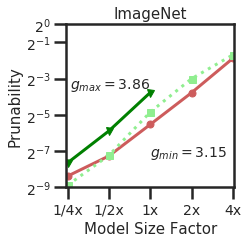

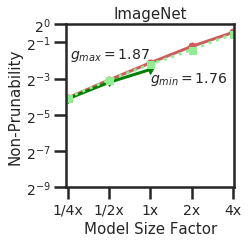

array([3.14551181, 3.86216022, 3.60887181])

In [33]:
leg_loc = (0.05, 1.3)

yticks = [0, 20, 40, 60]  ### CHANGED
yticks_log = [ 1/512, 1/128,  1/32, 1/8, 1/2, 1]  ### CHANGED

yticks_log2 = [0, 1/4, 1/2, 1]  ### CHANGED

print_ablation('ImageNet', ablation, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Network}$", 0.1,leg_loc, False,
                 "prune_imagenet", True, False, slopes)

leg_loc = (0.33, 0.01)
print_ablation('ImageNet', targeted_ablation, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Network}$", 0.1,leg_loc, False,
                 "nonprune_imagenet", True, True, slopes_no)
slopes

OPTS LOOKUP:
ID: 0, resnet, factor: 0.25, batch_size:8192
ID: 1, resnet, factor: 0.5, batch_size:4096
ID: 2, resnet, factor: 1, batch_size:3072
ID: 3, resnet, factor: 2, batch_size:1024
ID: 4, resnet, factor: 4, batch_size:512
ID: 5, resnet, factor: 0.25, batch_size:4096
ID: 6, resnet, factor: 0.25, batch_size:2048
ID: 7, resnet, factor: 0.5, batch_size:2048
ID: 8, resnet, factor: 1, batch_size:2048
ID: 9, resnet, factor: 0.25, batch_size:1024
ID: 10, resnet, factor: 0.5, batch_size:1024
ID: 11, resnet, factor: 1, batch_size:1024
ID: 12, inception, factor: 1, batch_size:512
ID: 13, inception, factor: 0.25, batch_size:512
ID: 14, inception, factor: 0.5, batch_size:512
ID: 15, inception, factor: 1, batch_size:512
ID: 16, inception, factor: 1, batch_size:512
ID: 17, inception, factor: 1, batch_size:512
ID: 18, inception, factor: 1, batch_size:512
ID: 19, resnet, factor: 0.25, batch_size:8192
ID: 20, resnet, factor: 0.5, batch_size:4096
ID: 21, resnet, factor: 1, batch_size:3072
ID: 22, re

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


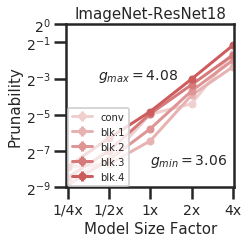

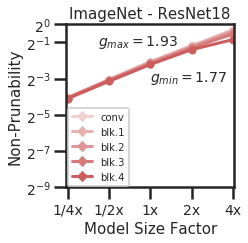

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


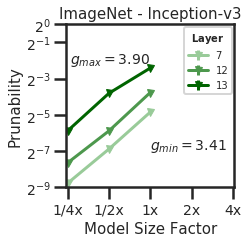

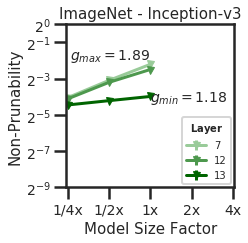

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:140: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:142: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


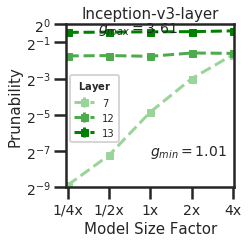

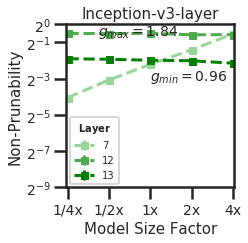

In [34]:
#Layersc=cImageNet

sys.path.append('../')
sys.path.append('../ImageNet/')
from ImageNet.experiments import experiments

opts = experiments.get_experiments('','')
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
range_len = 7

sizes = 5
levels = np.array(np.linspace(0.0, 1.0, num=range_len))
knockout_range = np.linspace(0.0, 1.0, num=range_len)
level_labels = ["{:.0f}".format(a*100) for a in levels]

range_len = 7
curves = 5
curve_labels = ['conv',  'blk.1', 'blk.2', 'blk.3','blk.4']
cm = seaborn.light_palette("indianred", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=curves+1)][1:]
curve_styles = ['-', '-', '-', '-', '-']
marker_styles = ['o', 'o', 'o', 'o', 'o']

sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3



ablation = np.zeros((curves, sizes, 2))
ablation_test = np.zeros((curves, sizes, 2))


for ID in range(5):
    for idx_layer, layer in enumerate([0,1,2,3,4]):

        #print('Processing ID:', ID)
        opt = opts[ID]    
        csv_file = opt.csv_dir + opt.name + '_robustness.csv'
        df = pd.read_csv(csv_file)

        size_idx = size_idx_map[opt.dnn.factor]

        rand_ablation_results = np.zeros((range_len))
        targeted_ablation_results = np.zeros(( range_len))
        for amount in range(range_len):
            rand_ablation_results[amount] = \
                np.array(df[df['cross'] == 0][df['evaluation_set'] == 'validation'][df['perturbation_layer'] == str(layer)] \
                    [df['perturbation_type'] == 2] \
                        [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])

        ablation[idx_layer, size_idx, 0] = get_threshold(np.expand_dims(rand_ablation_results, 0)) * (1/4) * opt.dnn.factor
        ablation_test[idx_layer, size_idx, 0] = 1/2**(4-size_idx) - ablation[idx_layer, size_idx, 0]
        

slopes = get_slope(ablation)
slopes_no = get_slope(ablation_test)

leg_loc = (0.01, 0.01)

yticks = [0, 20, 40, 60]  ### CHANGED
yticks_log = [ 1/512, 1/128,  1/32, 1/8, 1/2, 1]  ### CHANGED

yticks_log2 = [0, 1/4, 1/2, 1]  ### CHANGED

print_ablation('ImageNet-ResNet18', ablation, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"", 0.1,leg_loc, True,
                 "prune_imagenet_resnet_all_layer", True, False, slopes)

print_ablation('ImageNet - ResNet18', ablation_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"", 0.1,leg_loc, True,
                 "nonprune_imagenet_resnet_all_layer", True, True, slopes_no, ncol=1)

curves = 3
curve_labels = ['7',  '12', '13']
cm = seaborn.light_palette("darkgreen", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=4)][1:]
curve_styles = ['-', '-', '-']
marker_styles = ['v', 'v', 'v']

ablation = np.zeros((curves, sizes, 2))
ablation_test = np.zeros((curves, sizes, 2))
for ID in range(12,15):
    for idx_layer, layer in enumerate([7, 13, 15]):
        #print('Processing ID:', ID)
        opt = opts[ID]    
        csv_file = opt.csv_dir + opt.name + '_robustness.csv'
        df = pd.read_csv(csv_file)

        size_idx = size_idx_map[opt.dnn.factor]

        rand_ablation_results = np.zeros((range_len))
        for amount in range(range_len):
            rand_ablation_results[amount] = \
                np.array(df[df['cross'] == 0][df['evaluation_set'] == 'validation'][df['perturbation_layer'] == str(layer)] \
                    [df['perturbation_type'] == 2] \
                        [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])

        ablation[idx_layer, size_idx, 0] = get_threshold(np.expand_dims(rand_ablation_results, 0)) * (1/4) * opt.dnn.factor
        ablation_test[idx_layer, size_idx, 0] = 1/2**(4-size_idx) - ablation[idx_layer, size_idx, 0]
        
slopes = get_slope(ablation)
slopes_no = get_slope(ablation_test)

leg_loc = (0.7, 0.57)
yticks_log = [ 1/512, 1/128,  1/32, 1/8, 1/2, 1]  ### CHANGED

yticks_log2 = [0, 1/8, 1/4, 1/2]  ### CHANGED
print_ablation('ImageNet - Inception-v3', ablation, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Layer}$", 0.1,leg_loc, True,
                 "prune_imagenet_inception_all_layer", True, False, slopes)

leg_loc = (0.69, 0.02)
print_ablation('ImageNet - Inception-v3', ablation_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Layer}$", 0.1,leg_loc, True,
                 "nonprune_imagenet_inception_all_layer", True, True, slopes_no)

curves = 3
curve_labels = ['7',  '12', '13']
cm = seaborn.light_palette("green", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=4)][1:]
curve_styles = ['--', '--', '--']
marker_styles = ['s', 's', 's']
ablation = np.zeros((curves, sizes, 2))
targeted_ablation = np.zeros((curves, sizes, 2))
for ID in list(range(12,13)) + list(range(15,19)):
    for idx_layer, layer in enumerate([7, 13, 15]):
        #print('Processing ID:', ID)
        opt = opts[ID]    
        csv_file = opt.csv_dir + opt.name + '_robustness.csv'
        df = pd.read_csv(csv_file)

        size_idx = size_idx_map[opt.dnn.factor_end]

        rand_ablation_results = np.zeros((range_len))
        for amount in range(range_len):
            rand_ablation_results[amount] = \
                np.array(df[df['cross'] == 0][df['evaluation_set'] == 'validation'][df['perturbation_layer'] == str(layer)] \
                    [df['perturbation_type'] == 2] \
                        [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])

        if layer == 7:
            ablation[idx_layer, size_idx, 0] = get_threshold(np.expand_dims(rand_ablation_results, 0)) * (1/4) * factor_map[ID]
            ablation_test[idx_layer, size_idx, 0] = 1/2**(4-size_idx) - ablation[idx_layer, size_idx, 0]
        else:
            ablation[idx_layer, size_idx, 0] = get_threshold(np.expand_dims(rand_ablation_results, 0)) 
            ablation_test[idx_layer, size_idx, 0] = 1 - ablation[idx_layer, size_idx, 0]

        

slopes = get_slope(ablation)
slopes_no = get_slope(ablation_test)

leg_loc = (0.02, 0.28)
yticks_log = [ 1/512, 1/128,  1/32, 1/8, 1/2, 1]  ### CHANGED

yticks_log2 = [0, 1/4, 1/2,1]  ### CHANGED
print_ablation('Inception-v3-layer', ablation, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Layer}$", 0.1,leg_loc, True,
                 "prune_imagenet_inception_layer", True, False, slopes)

leg_loc = (0.02, 0.02)
print_ablation('Inception-v3-layer', ablation_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks_log, r"$\bf{Layer}$", 0.1,leg_loc, True,
                 "nonprune_imagenet_inception_layer", True, True, slopes_no)


OPTS LOOKUP:
ID: 0, resnet, factor: 0.25, batch_size:8192
ID: 1, resnet, factor: 0.5, batch_size:4096
ID: 2, resnet, factor: 1, batch_size:3072
ID: 3, resnet, factor: 2, batch_size:1024
ID: 4, resnet, factor: 4, batch_size:512
ID: 5, resnet, factor: 0.25, batch_size:4096
ID: 6, resnet, factor: 0.25, batch_size:2048
ID: 7, resnet, factor: 0.5, batch_size:2048
ID: 8, resnet, factor: 1, batch_size:2048
ID: 9, resnet, factor: 0.25, batch_size:1024
ID: 10, resnet, factor: 0.5, batch_size:1024
ID: 11, resnet, factor: 1, batch_size:1024
ID: 12, inception, factor: 1, batch_size:512
ID: 13, inception, factor: 0.25, batch_size:512
ID: 14, inception, factor: 0.5, batch_size:512
ID: 15, inception, factor: 1, batch_size:512
ID: 16, inception, factor: 1, batch_size:512
ID: 17, inception, factor: 1, batch_size:512
ID: 18, inception, factor: 1, batch_size:512
ID: 19, resnet, factor: 0.25, batch_size:8192
ID: 20, resnet, factor: 0.5, batch_size:4096
ID: 21, resnet, factor: 1, batch_size:3072
ID: 22, re

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

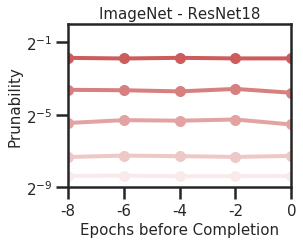

In [35]:
#Time - ImageNet

sys.path.append('../')
sys.path.append('../ImageNet/')
from ImageNet.experiments import experiments

opts = experiments.get_experiments('','')
range_len = 7
curves = 5
curve_labels = ['x1/4',  'x1/2', 'x1', 'x2', 'x4']
cm = seaborn.light_palette("indianred", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=5)]
curve_styles = ['-', '-', '-', '-', '-']
marker_styles = ['o', 'o', 'o', 'o', 'o']
sizes = 5
size_factors = np.array([-4, -3, -2, -1, 0])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['-8', '-6', '-4', '-2', '0']
crosses=3

ablation = np.zeros((curves, sizes, 2))
targeted_ablation = np.zeros((curves, sizes, 2))

# both are indexed [nn_type][size_factor]

for ID in range(19, 39):

    #print('Processing ID:', ID)
    opt = opts[ID]

    curve_idx = 0  # unregularized

    size_idx = size_idx_map[opt.dnn.factor]

    csv_file = opt.csv_dir + opt.name + '_robustness.csv'
    df = pd.read_csv(csv_file)
    
    rand_ablation_results = np.zeros((range_len))
    targeted_ablation_results = np.zeros((range_len))
    for amount in range(range_len):
        rand_ablation_results[amount] = \
            np.array(df[df['cross'] == 0][df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_type'] == 2] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        
        targeted_ablation_results[amount] = \
            np.array(df[df['cross'] == 0][df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_type'] == 4] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        
    ablation[size_idx][opt.time_step][0] = get_threshold(np.expand_dims(rand_ablation_results, 0)) * (1/4) * opt.dnn.factor 
    ablation[size_idx][opt.time_step][1] = 0
    targeted_ablation[size_idx][opt.time_step][0] = get_threshold(np.expand_dims(rand_ablation_results, 0)) * (1/4) * opt.dnn.factor
    targeted_ablation[size_idx][opt.time_step][1] = 0

for ID in range(5):

    #print('Processing ID:', ID)
    opt = opts[ID]

    curve_idx = 0  # unregularized

    size_idx = size_idx_map[opt.dnn.factor]
    
    csv_file = opt.csv_dir + opt.name + '_robustness.csv'
    df = pd.read_csv(csv_file)
    rand_ablation_results = np.zeros((range_len))
    targeted_ablation_results = np.zeros((range_len))
    for amount in range(range_len):
        rand_ablation_results[amount] = \
            np.array(df[df['cross'] == 0][df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_type'] == 2] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        
        targeted_ablation_results[amount] = \
            np.array(df[df['cross'] == 0][df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_type'] == 4] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        
    ablation[size_idx][-1][0] = get_threshold(np.expand_dims(rand_ablation_results, 0)) * (1/4) * opt.dnn.factor
    ablation[size_idx][-1][1] = 0
    targeted_ablation[size_idx][-1][0] = get_threshold(np.expand_dims(rand_ablation_results, 0)) * (1/4) * opt.dnn.factor
    targeted_ablation[size_idx][-1][1] = 0
    
data = ablation[:, :, 0]
stds = ablation[:, :, 1]
title = r'ImageNet - ResNet18'
leg_title = r"$\bf{Model} \bf{Size}$"
leg_flag = True
rand_base = 0.1


leg_loc = (0.7, 0.040)
yticks = [ 1/512, 1/128,  1/32, 1/8, 1/2, 1]  ### CHANGED

fig, ax = plt.subplots(figsize=(4, 3))
plt.title(title , fontsize=25)
plt.xlabel(r'Epochs before Completion', fontsize=25)
plt.ylabel('Prunability', fontsize=25)
plt.xlim((-4, 0))
plt.xticks(size_factors, size_labels)
plt.yticks(yticks)
ax.xaxis.tick_bottom() ### CHANGED
ax.yaxis.tick_left() ### CHANGED
plt.yscale('log', basey=2)
plt.ylim((np.min(yticks), np.max(yticks)))

for curve_idx in range(np.shape(data)[0]):
    non_0_idx = (data[curve_idx] != 0)
    plt.errorbar(size_factors[non_0_idx], data[curve_idx][non_0_idx], yerr=stds[curve_idx][non_0_idx], marker=marker_styles[curve_idx], color=curve_colors[curve_idx],
             linestyle=curve_styles[curve_idx], linewidth=4, markersize=10)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

if False:
    leg = plt.legend(curve_labels, loc=leg_loc, framealpha=0.8, fontsize=10, title=leg_title)
    leg.get_title().set_fontsize('12')
plt.rc('xtick',labelsize=8)

plt.show()
fig.savefig("prune_imagenet_dynamics.pdf",format='pdf', bbox_inches='tight',dpi=1000)
    